In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
import scipy

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

In [5]:
# prepare colors for plot
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
phasec = sns.color_palette("dana", n_colors=27)


# prepare colors for plot
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana2", cmap)
phasecf = sns.color_palette("dana2", n_colors=27)

/tmp/ipykernel_28780/813501115.py:6: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana", cmap)
/tmp/ipykernel_28780/813501115.py:15: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana2", cmap)


In [6]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]

In [7]:
# for female:
f_df= female_df.groupby(['age','uuid']).mean()
#f_df = f_df.query('age<100')

# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4','e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33']
f_df.reset_index(inplace=True)
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)


avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

In [8]:
f_data=f_df.copy()

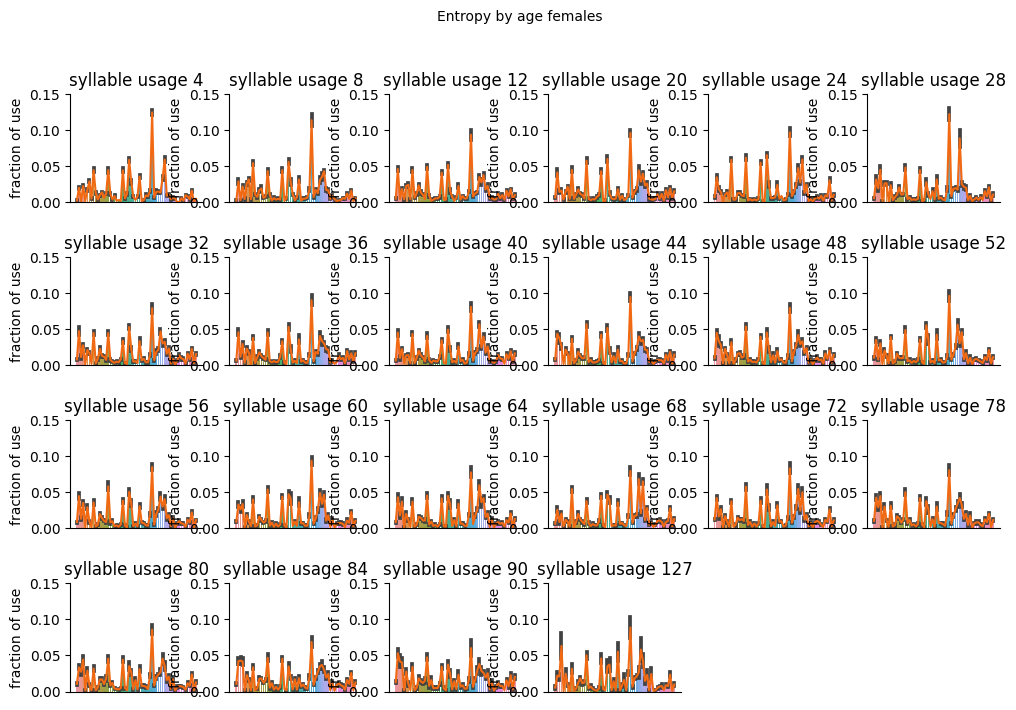

In [9]:
fig=plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Entropy by age females", fontsize=10, y=0.95)
n=0
ages=[]
ent=[]

for age,_df in enumerate(f_data.groupby('age')):
    ages.extend(_df[1].index.get_level_values('age').to_numpy())
    data_temp = _df[1].to_numpy()
    arr = scipy.stats.entropy(data_temp, axis=1)
    ent.extend(arr)
    ax = plt.subplot(6, 6, n + 1)
    sns.barplot(data_temp, errorbar='se',ax=ax)
    sns.lineplot(np.mean(data_temp, axis=0),ax=ax, color='#f16913')
    ax.set_title('syllable usage ' + str(_df[1].index.get_level_values('age').unique().to_numpy()[0]))
    ax.set_ylim(0,0.15)
    ax.set_xticks([])
    ax.set_ylabel('fraction of use')
    n=n+1
    sns.despine()

In [10]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'female_entropy_examples.pdf')

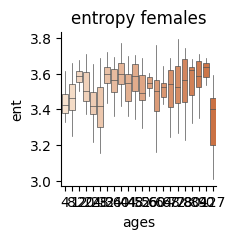

In [11]:
# plot entropy values
dfm=pd.DataFrame()
ages = [str(num) for num in ages]
dfm['ages']=ages
dfm['ent']=ent
dfm['sex'] = ['m'] * len(ages)
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=dfm, x=dfm.ages.astype('int'), y="ent",
             palette = phasecf, 
            dodge=True, 
            showfliers=False, 
            linewidth=0.5, 
            showcaps=False,
           )
#sns.scatterplot(data=dfm, x="ages", y="ent",palette = phasec, alpha=0.50,s=10)
ax.set_title('entropy females')
#ax.set_ylim(3,3.5)
sns.despine()

In [12]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'female_entropy_boxplots.pdf')

In [13]:
from scipy.stats import entropy
df=f_df.copy()

In [14]:
ent = pd.Series(entropy(df.to_numpy() + 1e-4, axis=1), index=df.index)
ent.name = 'entropy'

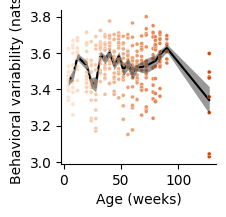

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
ax = sns.scatterplot(
    data=ent.reset_index(),
    x="age",
    y="entropy",
    hue="age",
    palette=cmf,
    linewidths=0,
    s=8,
    legend=False,
)
ax = sns.lineplot(
    data=ent.reset_index(),
    x="age",
    y="entropy",
    zorder=-1,
    color="black",
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)

ax.set(xlabel="Age (weeks)", ylabel="Behavioral variability (nats)", yticks = [3.0,3.2,3.4,3.6,3.8])
sns.despine()

In [16]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'female_entropy_scatter.pdf')